In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import covalent as ct

In [2]:
@ct.electron
def create_data(n):
    X = np.linspace(0, 2*np.pi, n)
    X.requires_grad = False
    Y = np.sin(X)
    X_test = np.linspace(0.2, 2*np.pi+0.2, n)
    Y_test = np.sin(X_test)
    return X, Y, X_test, Y_test

In [3]:
@ct.electron
def plot_data(X_train, Y_train, X_test, Y_test):
    plt.scatter(X_train, Y_train, color='#219ebc', label='Training Data')
    plt.scatter(X_test, Y_test, color='#fb8500', alpha=0.5, label='Test Data')
    plt.legend()
    plt.savefig('input_data.png')

In [ ]:
X, Y, X_test, Y_test = create_data(5)

In [4]:
dev = qml.device('default.qubit', wires=1)
@qml.qnode(dev)
def quantum_circuit(datapoint, params):
    # Encode the input data as an RX rotation
    qml.RX(datapoint, wires=0)
    # # Create a rotation based on the angles in "params"
    qml.Rot(params[0], params[1], params[2], wires=0)
    # # We return the expected value of a measurement along the Z axis 
    return qml.expval(qml.PauliZ(wires=0))

In [5]:
@ct.electron
def cost_fn(params):
    # We get the predictions of the quantum circuit for a specific 
    # set of parameters along the entire input dataset
    predictions = [quantum_circuit(x, params)  for x in X]
    # We calculate the cost including any classical postprocessing
    cost = loss_func(predictions)
    return cost

In [6]:
@ct.electron
def loss_func(predictions):
    # This is a postprocessing step. Here we use a least squares metric 
    # based on the predictions of the quantum circuit and the outputs 
    # of the training data points.
    total_losses = 0
    for i in range(len(Y)):
        output = Y[i]
        prediction = predictions[i]
        loss = (prediction - output)**2
        total_losses += loss
    return total_losses

In [7]:
@ct.electron
def gradient_descent():
    opt = qml.GradientDescentOptimizer(stepsize=0.3)
    params = np.array([0.1,0.1,0.1],requires_grad=True)
    for i in range (100):
        # Over each step the parameters change to give a better cost
        params, prev_cost = opt.step_and_cost(cost_fn,params) 
        if i%10 == 0:
             # We print the result after every 10 steps
            print(f'Step = {i} Cost = {cost_fn(params)}')
    return params

In [8]:
@ct.lattice
def workflow():
    X, Y, X_test, Y_test = create_data(5)
    plot_data(X, Y, X_test, Y_test)
    params = gradient_descent()
    return params

In [9]:
workflow.draw()

In [10]:
ct.dispatch(workflow)()

'8cc26886-f412-422d-b570-9bcc168ebad0'

NameError: name 'X_train' is not defined

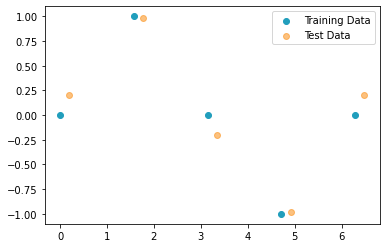

In [11]:
params = workflow()
print(params)

In [ ]:
test_predictions = []
X, Y, X_test, Y_test = create_data(5)
for x_test in X_test:
    prediction = quantum_circuit(x_test,params)
    test_predictions.append(prediction)

TypeError: 'NoneType' object is not subscriptable

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(X, Y, c='#219ebc', label='Training data')
ax1.plot(X_test,Y_test, c='#fb8500', label='Test data')
ax1.scatter(X_test,test_predictions, s=30, c='k', marker="x", label='Model Predicitons')
plt.xlabel("Inputs")
plt.ylabel("Outputs")
plt.title("QML results")

plt.legend(loc='upper right');
plt.show()